In [17]:
import random
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
from dataclasses import dataclass
from typing import List, Optional, Literal

### Comparing Arithmetic and Wasserstein Averaging of Distributions

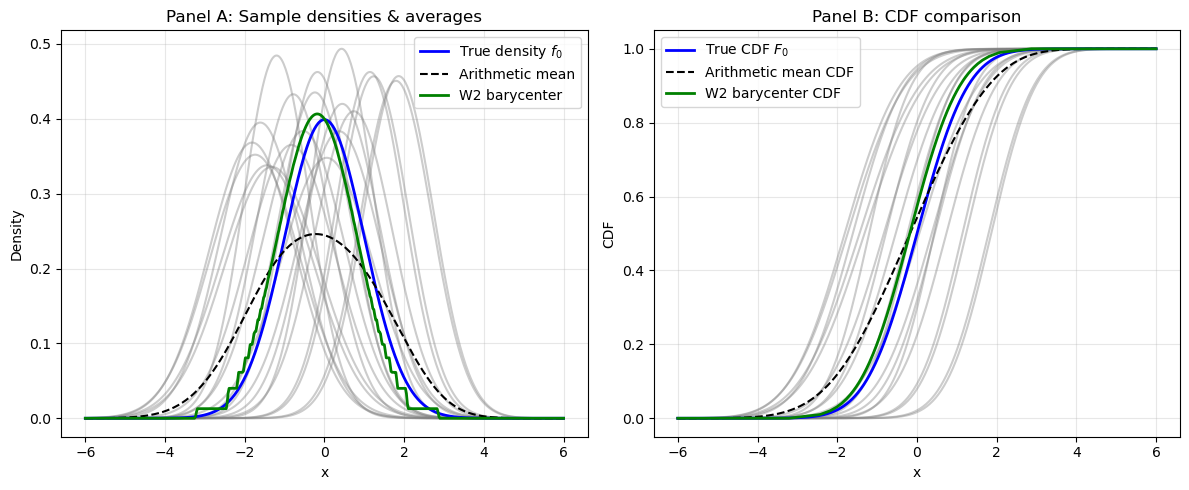

In [18]:
# --- Base distribution ---
f0 = norm.pdf
F0 = norm.cdf
q0 = norm.ppf

# --- Generate random (a,b) for location-scale model ---
n = 20
np.random.seed(42)
a = np.random.uniform(0.8, 1.2, size=n)   # scales
b = np.random.uniform(-2, 2, size=n)      # shifts

x = np.linspace(-6, 6, 500)
densities, cdfs = [], []

for i in range(n):
    fi = (1/a[i]) * f0((x - b[i]) / a[i])
    Fi = norm.cdf((x - b[i]) / a[i])
    densities.append(fi)
    cdfs.append(Fi)

densities = np.array(densities)
cdfs = np.array(cdfs)

# Arithmetic mean density & CDF
f_mean = densities.mean(axis=0)
F_mean = cdfs.mean(axis=0)

# Wasserstein barycenter via quantile averaging
u = np.linspace(0.001, 0.999, 100)
quantiles = np.array([a[i] * q0(u) + b[i] for i in range(n)])
q_bar = np.mean(quantiles, axis=0)

F_bar = np.interp(x, q_bar, np.linspace(0, 1, len(q_bar)))
f_bar = np.gradient(F_bar, x)

# True base
f_true = f0(x)
F_true = F0(x)

# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Panel A: sample densities
for fi in densities:
    axes[0].plot(x, fi, color="gray", alpha=0.4)
axes[0].plot(x, f_true, color="blue", linewidth=2, label="True density $f_0$")
axes[0].plot(x, f_mean, color="black", linestyle="--", label="Arithmetic mean")
axes[0].plot(x, f_bar, color="green", linewidth=2, label="W2 barycenter")
axes[0].set_title("Panel A: Sample densities & averages")
axes[0].set_xlabel("x"); axes[0].set_ylabel("Density")
axes[0].legend(); axes[0].grid(alpha=0.3)


# Panel B: CDFs
for Fi in cdfs:
    axes[1].plot(x, Fi, color="gray", alpha=0.4)
axes[1].plot(x, F_true, color="blue", linewidth=2, label="True CDF $F_0$")
axes[1].plot(x, F_mean, color="black", linestyle="--", label="Arithmetic mean CDF")
axes[1].plot(x, F_bar, color="green", linewidth=2, label="W2 barycenter CDF")
axes[1].set_title("Panel B: CDF comparison")
axes[1].set_xlabel("x"); axes[1].set_ylabel("CDF")
axes[1].legend(); axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### WKMeans Clustering Distributions with Different Means and Variances

In [19]:
@dataclass
class WKMeansResult:
    centroids: np.ndarray     # shape (k, p)
    labels: np.ndarray        # shape (n,)
    losses: List[float]
    iter: int

class WassersteinKMeans:
    def __init__(self, n_clusters=2, p=2, max_iter=100, tol=1e-6, random_state=None):
        self.n_clusters = n_clusters
        self.p = p
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.centroids_ = None
        self.labels_ = None
        if random_state is not None:
            np.random.seed(random_state)
            random.seed(random_state)
    
    def _wasserstein_empirical(self, alpha: np.ndarray, beta: np.ndarray, p=2):
        """
        Compute empirical Wasserstein-p distance between two empirical measures.

        Parameters
        ----------
        alpha : array-like
            Samples from distribution μ.
        beta : array-like
            Samples from distribution ν.
        p : int
            Order of the Wasserstein distance (default=2).

        Returns
        -------
        Wp : float
            Wasserstein-p distance.
        """
        alpha = np.sort(np.array(alpha))
        beta = np.sort(np.array(beta))

        N = min(len(alpha), len(beta))
        return (np.mean(np.abs(alpha[:N] - beta[:N]) ** p)) ** (1 / p)
    
    def _wasserstein_barycenter(self, samples, p=2):
        """
        Compute the Wasserstein barycenter (centroid) of a list of 1D empirical samples.
        - For p=1: coordinate-wise median of order statistics.
        - For p=2: coordinate-wise mean of order statistics.
        """
        N = len(samples[0])
        # Stack sorted samples
        S = np.vstack([np.sort(s)[:N] for s in samples])
        if p == 1:
            return np.median(S, axis=0)
        else:
            return np.mean(S, axis=0)

    def fit(self, X):
        """
        Run WK-means on a list of empirical distributions (arrays of equal length).
        """
        n_samples = len(X)
        if n_samples < self.n_clusters:
            raise ValueError("Number of samples must be >= number of clusters.")

        # Random initialization of centroids
        self.centroids_ = [X[i] for i in np.random.choice(n_samples, self.n_clusters, replace=False)]
        self.labels_ = np.zeros(n_samples, dtype=int)

        losses = []
        iteration = 0
        while iteration < self.max_iter:
            # Assignment step
            for i, sample in enumerate(X):
                distances = [self._wasserstein_empirical(sample, c, p=self.p) for c in self.centroids_]
                self.labels_[i] = np.argmin(distances)

            # Update step
            new_centroids = []
            for j in range(self.n_clusters):
                cluster_members = [X[i] for i in range(n_samples) if self.labels_[i] == j]
                if cluster_members:
                    new_centroids.append(self._wasserstein_barycenter(cluster_members, p=self.p))
                else:
                    # Handle empty cluster by reinitializing
                    new_centroids.append(random.choice(X))

            # Check convergence
            shift = sum(
                self._wasserstein_empirical(self.centroids_[j], new_centroids[j], p=self.p)
                for j in range(self.n_clusters)
            )
            self.centroids_ = new_centroids
            
            iteration += 1
            losses.append(shift)

            if shift < self.tol:
                break
        if iteration == self.max_iter:
            print(f"Warning: WK-means algorithm may not converge after {self.max_iter} iterations")

        return WKMeansResult(
            centroids=np.array(self.centroids_),
            labels=self.labels_,
            losses=losses,
            iter=iteration
        )
    
    def predict(self, X):
        """
        Assign new samples to clusters.
        """
        labels = []
        for sample in X:
            distances = [self.wasserstein_empirical(sample, c, p=self.p) for c in self.centroids_]
            labels.append(np.argmin(distances))
        return np.array(labels)

Cluster labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Label counts: [30 30]


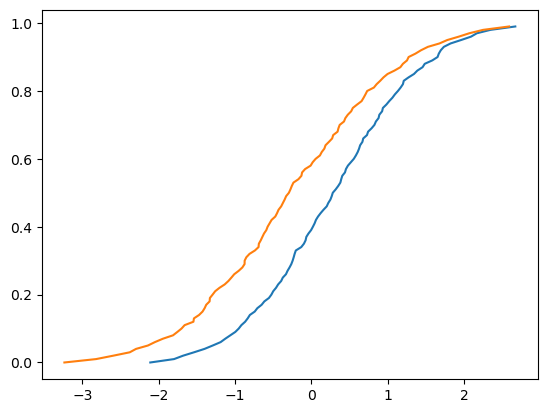

4 [0.4591610328799746, 0.21974828972730792, 0.025130352470695415, 0.0]


In [20]:
# Example: synthetic distributions (two regimes: low vs high variance)
rng = np.random.default_rng(0)

X = []
for _ in range(30):
    X.append(rng.normal(.3, 1, size=100))   # regime 1
for _ in range(30):
    X.append(rng.normal(-.3, 1.2, size=100))   # regime 2

wkmeans = WassersteinKMeans(n_clusters=2, p=1, random_state=42)
result = wkmeans.fit(X)

print("Cluster labels:", result.labels)
print("Label counts:", np.bincount(result.labels))

plt.plot(result.centroids[0], np.arange(len(result.centroids[0])) / len(result.centroids[0]), label='Centroid 1')
plt.plot(result.centroids[1], np.arange(len(result.centroids[1])) / len(result.centroids[1]), label='Centroid 2')
plt.show()

print(result.iter, result.losses)

### Time Series Segmentation and Regime Detection

In [21]:
def segment_time_series(series, window, step):
    """
    Segment a 1D time series into overlapping windows.

    Parameters
    ----------
    series : array-like
        Input time series (e.g., log-returns).
    window : int
        Length of each segment (h1).
    step : int
        Step size (overlap offset, h2).
        - step < window => overlapping segments
        - step = window => disjoint segments
    Returns
    -------
    segments : list of np.ndarray
        List of segments, each of length `window`.
    """
    series = np.asarray(series, dtype=float).ravel()
    n = len(series)
    segments = []
    for start in range(0, n - window + 1, step):
        segment = series[start:start + window]
        segments.append(segment)
    return segments

def plot_regimes_over_price(prices, segments, labels, window, step, title="Market Regimes", times=None):
    """
    Plot price series with coloring by WK-means cluster membership.

    Parameters
    ----------
    prices : array-like
        Full price series.
    segments : list of arrays
        Segmented returns used in WK-means.
    labels : array-like
        Cluster assignment for each segment.
    window : int
        Segment length (same as used in segmenting).
    step : int
        Step size between segments.
    title : str
        Plot title.
    """
    prices = np.asarray(prices)
    if times is None:
        times = np.arange(len(prices))
    fig, ax = plt.subplots(figsize=(12, 5))

    # Default color map: cluster 0 = green, cluster 1 = red, etc.
    cmap = plt.get_cmap("tab10", len(set(labels)))

    # Assign each segment's cluster to its covered price indices
    n_segments = len(segments)
    colors = np.zeros(len(prices))
    counts = np.zeros(len(prices))

    for idx, seg in enumerate(segments):
        start = idx * step
        end = start + window
        if end >= len(prices):
            break
        colors[start:end] += labels[idx]
        counts[start:end] += 1

    # Average cluster assignment where segments overlap
    avg_labels = np.divide(colors, counts, out=np.zeros_like(colors), where=counts > 0)

    # Plot price series, coloring by cluster
    scatter = ax.scatter(
        times,
        prices,
        c=avg_labels,
        cmap=cmap,
        s=10,
        alpha=0.8
    )

    ax.set_title(title)
    ax.set_xlabel("Time (index)")
    ax.set_ylabel("Price")
    cbar = plt.colorbar(scatter, ax=ax, ticks=range(len(set(labels))))
    cbar.set_label("Cluster")
    plt.show()

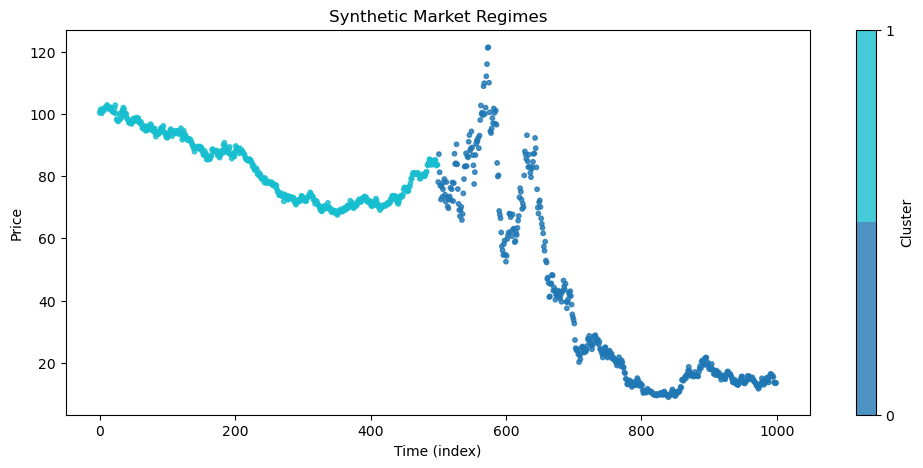

In [22]:
# Synthetic demo: two regimes (low vol vs high vol)
rng = np.random.default_rng(1)
n_points = 1000
returns = np.concatenate([
    rng.normal(0, 0.01, size=n_points // 2),
    rng.normal(0, 0.05, size=n_points // 2),
])
prices = 100 * np.exp(np.cumsum(returns))

# Segment returns
window, step = 50, 25
segments = segment_time_series(returns, window, step)

# Fit WK-means
wkmeans = WassersteinKMeans(n_clusters=2, p=2, random_state=42)
result = wkmeans.fit(segments)

# Plot regimes
plot_regimes_over_price(prices, segments, result.labels, window, step, title="Synthetic Market Regimes")

### WK-means Regime Detection in Merton-Jump-Diffusion

In [23]:
def simulate_merton_jump_diffusion(
    T=1.0, N=252, S0=100, 
    mu=0.05, sigma=0.2, 
    lam=1.0, gamma=-0.1, delta=0.2,
    random_state=None
):
    """
    Simulate a Merton jump diffusion price path.

    Parameters
    ----------
    T : float
        Total time horizon.
    N : int
        Number of time steps.
    S0 : float
        Initial price.
    mu : float
        Drift term.
    sigma : float
        Volatility of diffusion part.
    lam : float
        Intensity (expected jumps per unit time).
    gamma : float
        Mean of log(1+V) jump size distribution.
    delta : float
        Std of log(1+V) jump size distribution.
    random_state : int or None
        Random seed for reproducibility.

    Returns
    -------
    times : ndarray
        Time grid.
    prices : ndarray
        Simulated price path.
    """
    if random_state is not None:
        np.random.seed(random_state)

    dt = T / N
    times = np.linspace(0, T, N+1)
    prices = np.zeros(N+1)
    prices[0] = S0

    for t in range(1, N+1):
        Z = np.random.normal(0, 1)
        # Diffusion part
        dW = np.sqrt(dt) * Z
        drift = (mu - 0.5 * sigma**2) * dt
        diffusion = sigma * dW

        # Jump part
        Nj = np.random.poisson(lam * dt)   # number of jumps
        if Nj > 0:
            jumps = np.sum(np.random.normal(gamma, delta, Nj))
        else:
            jumps = 0.0

        prices[t] = prices[t-1] * np.exp(drift + diffusion + jumps)

    return times, prices

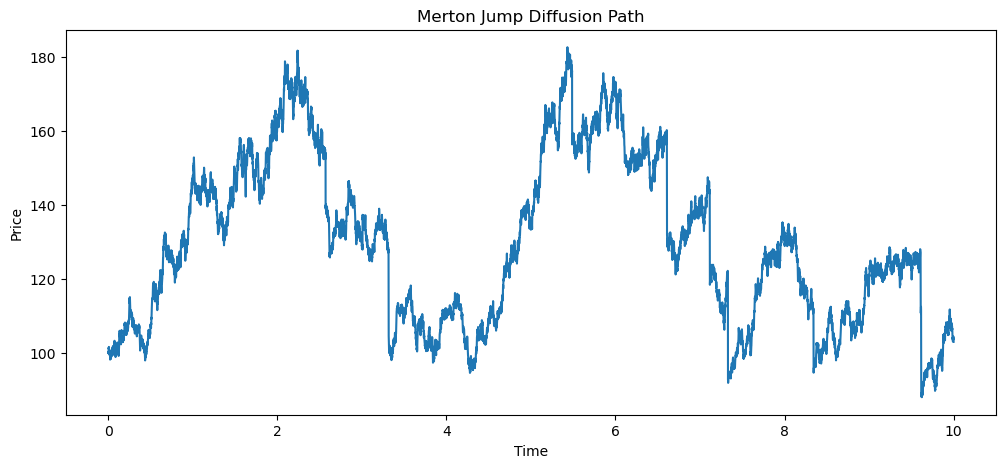

In [24]:
# Simulate a 2-year path with frequent jumps
times, prices = simulate_merton_jump_diffusion(
    T=10.0, N=10000, S0=100,
    mu=0.05, sigma=0.2,
    lam=2.0, gamma=-0.05, delta=0.1,
    random_state=42
)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(times, prices)
plt.title("Merton Jump Diffusion Path")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

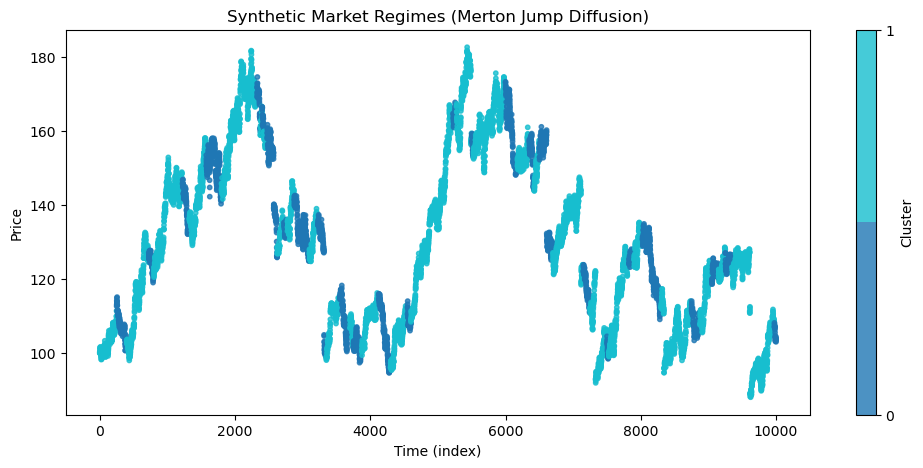

In [25]:
returns = np.diff(np.log(prices))
window, step = 100, 25
segments = segment_time_series(returns, window, step)

# Fit WK-means
wkmeans = WassersteinKMeans(n_clusters=2, p=1, random_state=42)
result = wkmeans.fit(segments)

# Plot regimes
plot_regimes_over_price(prices, segments, wkmeans.labels_, window, step, title="Synthetic Market Regimes (Merton Jump Diffusion)")

### Visualizing Clusters in Mean-Variance Space

In [26]:
def segment_stats(segments, use_std=False):
    """
    Compute (mean, variance) or (mean, std) for each segment.
    Returns two numpy arrays of shape (n_segments,).
    """
    segs = [np.asarray(s, dtype=float).ravel() for s in segments]
    means = np.array([s.mean() for s in segs])
    variances = np.array([s.var(ddof=0) for s in segs])
    if use_std:
        return means, np.sqrt(variances)
    return means, variances


def scatter_mean_variance(
    segments,
    labels,
    title="Segments in Mean–Variance Space",
    use_std=False,
    alpha=0.8,
    s=18,
    show_centroids=True,
    legend=True
):
    """
    Scatter plot of segments in (mean, variance) or (mean, std) space, colored by cluster labels.

    Parameters
    ----------
    segments : list[np.ndarray]
        List of return windows (equal length recommended).
    labels : array-like of int
        Cluster assignment for each segment (0..K-1).
    title : str
        Plot title.
    use_std : bool
        If True, y-axis is standard deviation; else variance.
    alpha : float
        Point transparency.
    s : int
        Marker size.
    show_centroids : bool
        If True, overlay cluster centroids computed from (mean, var/std) of members.
    legend : bool
        If True, show legend for clusters.
    """
    labels = np.asarray(labels, dtype=int)
    means, v_or_s = segment_stats(segments, use_std=use_std)

    K = int(labels.max()) + 1
    cmap = plt.get_cmap("tab10", K)

    plt.figure(figsize=(8, 6))
    for k in range(K):
        mask = labels == k
        plt.scatter(
            v_or_s[mask], means[mask],
            s=s, alpha=alpha, color=cmap(k), label=f"Cluster {k}"
        )

    # Optional centroid overlay (in mean–variance space, not Wasserstein barycenters)
    if show_centroids:
        for k in range(K):
            mask = labels == k
            if np.any(mask):
                c_mean = means[mask].mean()
                c_var = v_or_s[mask].mean()
                plt.scatter(
                    [c_var], [c_mean],
                    s=160, edgecolor="black", linewidth=1.2,
                    color=cmap(k), marker="X", zorder=5
                )

    xlab = "Std. Dev." if use_std else "Variance"
    plt.xlabel(xlab)
    plt.ylabel("Mean")
    plt.title(title)
    if legend:
        plt.legend(frameon=False)
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

def plot_centroids_cdf(centroids, title="WK-means Centroids CDFs"):
    """
    Plot the CDFs of WK-means centroids.

    Parameters
    ----------
    centroids : np.ndarray
        Array of shape (k, p) where each row is a centroid.
    title : str
        Plot title.
    """
    plt.figure(figsize=(8, 6))
    cmap = plt.get_cmap("tab10", len(centroids))
    for i, c in enumerate(centroids):
        sorted_c = np.sort(c)
        cdf = np.arange(1, len(c) + 1) / len(c)
        plt.plot(sorted_c, cdf, label=f'Centroid {i}', color=cmap(i))
    
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("CDF")
    plt.legend()
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

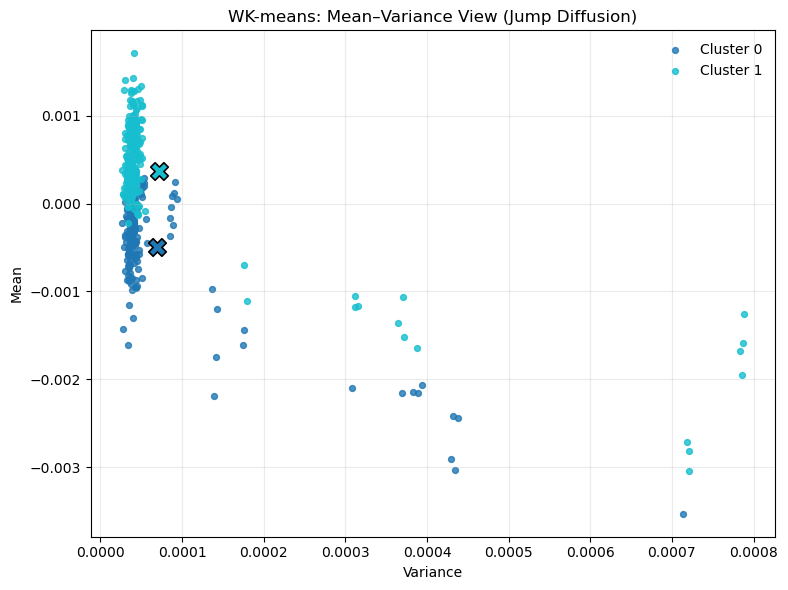

In [27]:
# Assuming you've already built `segments` and fitted `wkmeans` from earlier steps:
scatter_mean_variance(
    segments,
    wkmeans.labels_,
    title="WK-means: Mean–Variance View (Jump Diffusion)",
    use_std=False,         # set True to plot mean–std instead
    show_centroids=True
)

### Detecting S&P 500 Regimes with Hourly Data

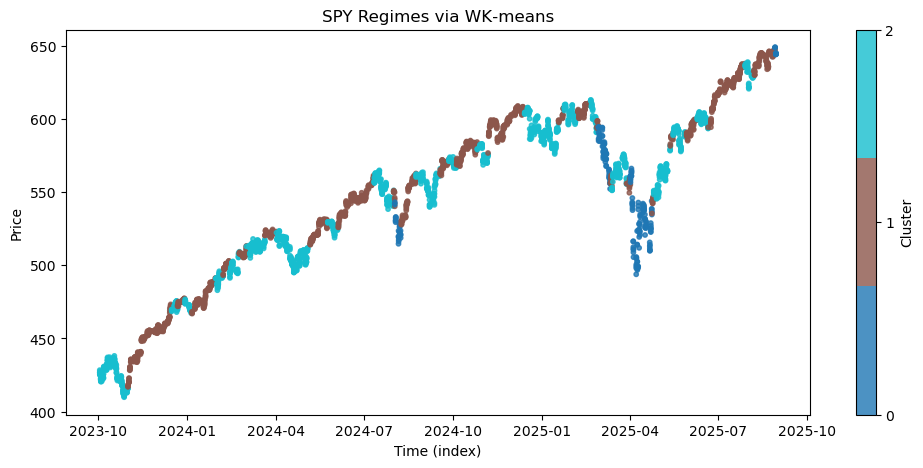

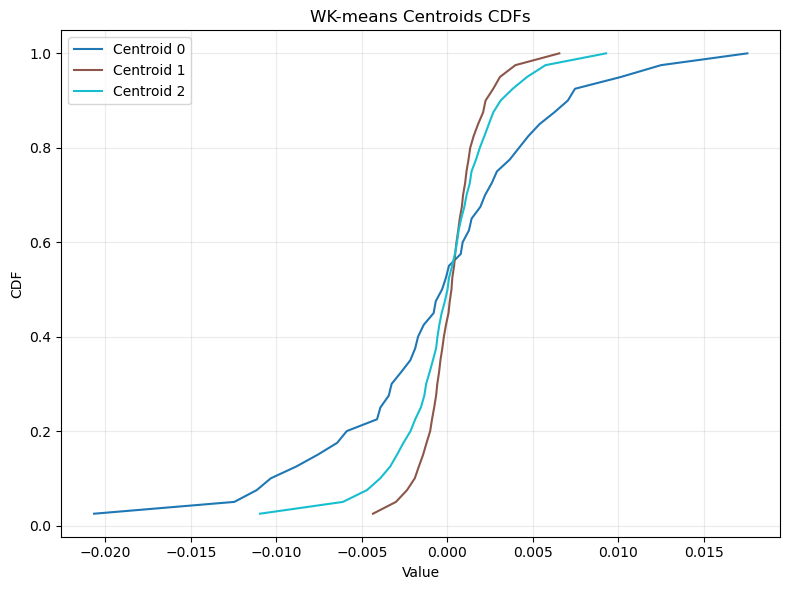

Completed pipeline. Label counts: [ 23 173 134]


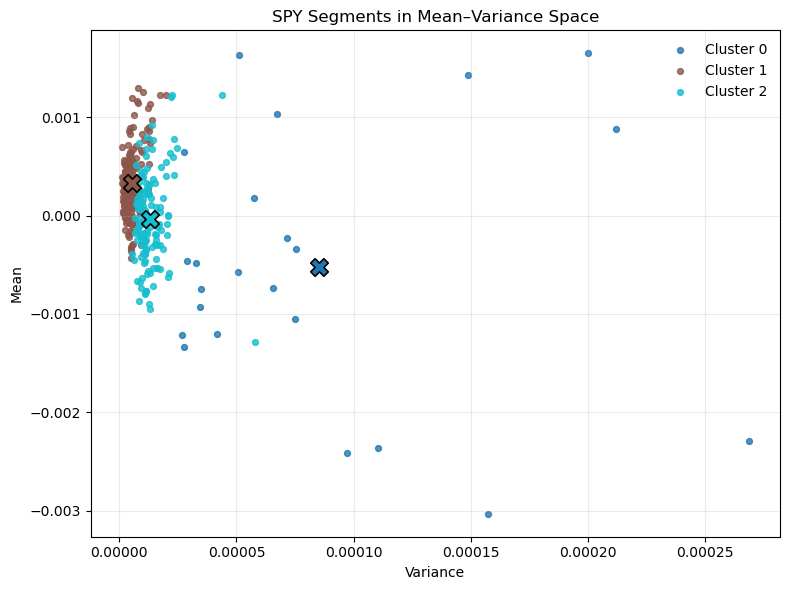

In [28]:
def run_wk_spy_pipeline(start_date="2023-10-01", end_date="2025-09-01", interval="1h", window=40, step=10, k=2, p=1):
    # 1. Download SPY close prices
    spy = yf.download("SPY", start=start_date, end=end_date, interval=interval, progress=False)
    prices = spy["Close"].values.reshape(-1)

    # 2. Compute log returns
    log_returns = np.diff(np.log(prices))
    times = spy.index

    # 3. Segment returns
    segments = segment_time_series(log_returns, window=window, step=step)

    # 4. WK-means clustering
    wk = WassersteinKMeans(n_clusters=k, p=p, random_state=42)
    result = wk.fit(segments)

    # 5. Plot regimes over price
    # Note: prices array is 1 longer than returns; to align, you might drop first window part etc.
    plot_regimes_over_price(prices, segments, result.labels, window, step, title="SPY Regimes via WK‐means", times=times)
    plot_centroids_cdf(result.centroids, title="WK-means Centroids CDFs")

    return {
        "prices": prices,
        "log_returns": log_returns,
        "segments": segments,
        "labels": result.labels,
        "centroids": result.centroids
    }

# Example usage
if __name__ == "__main__":
    result = run_wk_spy_pipeline(p=1, k=3)
    print("Completed pipeline. Label counts:", np.bincount(result["labels"]))
    scatter_mean_variance(
        result["segments"],
        result["labels"],
        title="SPY Segments in Mean–Variance Space",
        use_std=False,
        show_centroids=True
    )

### MK-means Clustering

In [29]:
@dataclass
class MKMeansResult:
    centroids: np.ndarray     # shape (k, p)
    labels: np.ndarray        # shape (n_samples,)
    losses: List[float]       # L2 shift per iteration
    iters: int


class MomentKMeans:
    """
    K-means on the first `p_moments` raw moments of segments.
    - Uses Euclidean distance in moment space (after optional z-scoring).
    - k-means++ initialization.

    Fit input: a list of segments (1D arrays of equal length recommended).
    """

    def __init__(
        self,
        n_clusters: int = 2,
        p_moments: int = 4,
        standardize: bool = True,
        max_iter: int = 100,
        tol: float = 1e-6,
        init: Literal["kmeans++", "random"] = "kmeans++",
        random_state: Optional[int] = None
    ):
        if n_clusters < 2:
            raise ValueError("n_clusters must be >= 2")
        if p_moments < 1:
            raise ValueError("p_moments must be >= 1")
        self.k = n_clusters
        self.p = p_moments
        self.standardize = standardize
        self.max_iter = max_iter
        self.tol = tol
        self.init = init
        self.random_state = random_state
        if random_state is not None:
            np.random.seed(random_state)
            random.seed(random_state)

        self.centroids_: Optional[np.ndarray] = None
        self.labels_: Optional[np.ndarray] = None
        self._features_: Optional[np.ndarray] = None  # cached feature matrix (n, p)
        
    def _moments_vector(self, x: np.ndarray, p: int) -> np.ndarray:
        """
        First p raw moments of a 1D sample x (finite-length empirical distribution).
        m_n = E[X^n] estimated by sample average.
        Returns shape (p,)
        """
        x = np.asarray(x, dtype=float).ravel()
        return np.array([np.mean(x**n) for n in range(1, p + 1)], dtype=float)


    def _zscore_columns(self, M: np.ndarray, eps: float = 1e-12) -> np.ndarray:
        """Column-wise z-score standardization (mean 0, var 1)."""
        mu = M.mean(axis=0)
        sd = M.std(axis=0)
        return (M - mu) / np.maximum(sd, eps)

    def _build_features(self, segments: List[np.ndarray]) -> np.ndarray:
        F = np.vstack([self._moments_vector(s, self.p) for s in segments]).astype(float)
        return self._zscore_columns(F) if self.standardize else F

    def _init_centroids(self, F: np.ndarray) -> np.ndarray:
        n = F.shape[0]
        if self.init == "random":
            idx = np.random.choice(n, self.k, replace=False)
            return F[idx].copy()

        # k-means++
        centroids = []
        idx0 = random.randrange(n)
        centroids.append(F[idx0])
        for _ in range(1, self.k):
            d2 = np.min(((F[:, None, :] - np.array(centroids)[None, :, :]) ** 2).sum(axis=2), axis=1)
            probs = d2 / d2.sum() if d2.sum() > 0 else np.ones(n) / n
            idx_next = np.random.choice(n, p=probs)
            centroids.append(F[idx_next])
        return np.vstack(centroids)

    def fit(self, segments: List[np.ndarray]) -> MKMeansResult:
        if len(segments) < self.k:
            raise ValueError("Number of samples must be >= n_clusters.")
        F = self._build_features(segments)      # (n, p)
        self._features_ = F
        C = self._init_centroids(F)             # (k, p)
        labels = np.zeros(F.shape[0], dtype=int)
        losses: List[float] = []

        for it in range(1, self.max_iter + 1):
            # assign
            d2 = ((F[:, None, :] - C[None, :, :]) ** 2).sum(axis=2)  # (n, k)
            labels = d2.argmin(axis=1)

            # update
            newC = np.zeros_like(C)
            for j in range(self.k):
                mask = (labels == j)
                if not np.any(mask):
                    # re-seed empty cluster
                    newC[j] = F[np.random.randint(0, F.shape[0])]
                else:
                    newC[j] = F[mask].mean(axis=0)

            # shift (L2 across centroids)
            shift = float(np.linalg.norm(C - newC))
            losses.append(shift)
            C = newC
            if shift < self.tol:
                break

        self.centroids_ = C
        self.labels_ = labels
        return MKMeansResult(C, labels, losses, it)

    def predict(self, segments: List[np.ndarray]) -> np.ndarray:
        if self.centroids_ is None:
            raise RuntimeError("Model not fitted yet.")
        F = self._build_features(segments)
        d2 = ((F[:, None, :] - self.centroids_[None, :, :]) ** 2).sum(axis=2)
        return d2.argmin(axis=1)

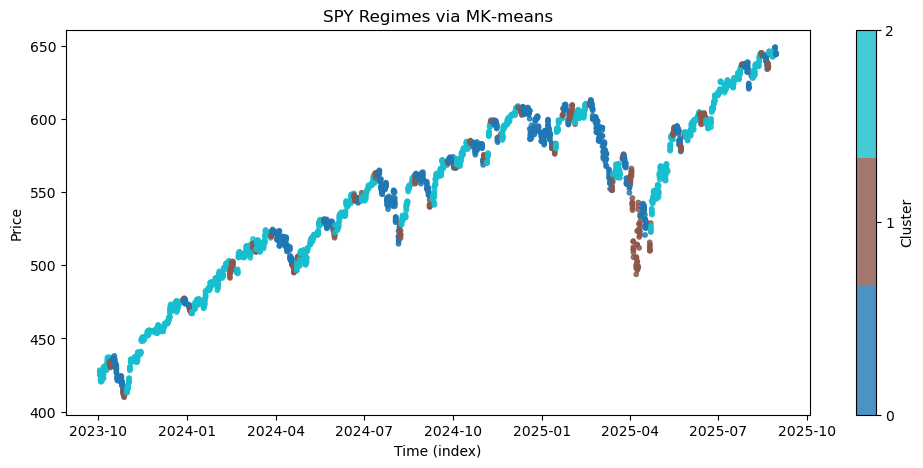

Completed pipeline. Label counts: [120   7 203]


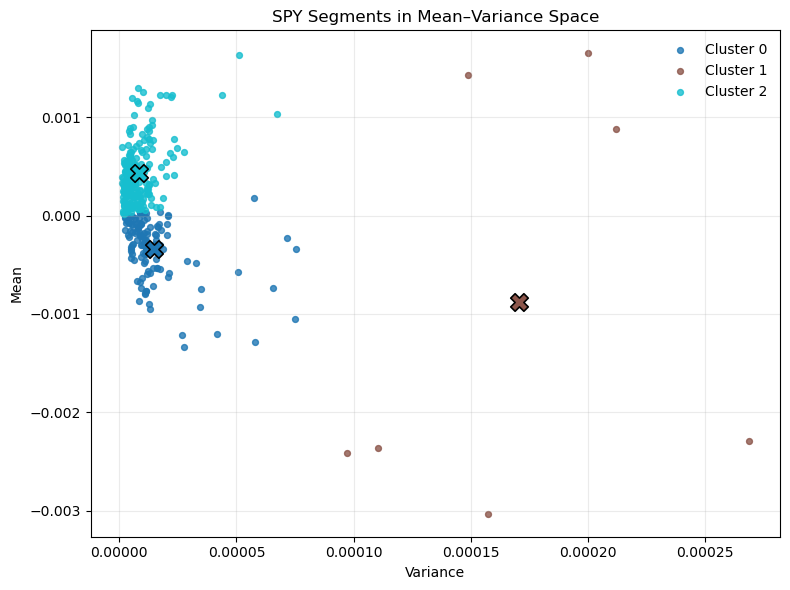

In [30]:
def run_mk_spy_pipeline(start_date="2023-10-01", end_date="2025-09-01", interval="1h", window=40, step=10, k=2, p=4):
    # 1. Download SPY close prices
    spy = yf.download("SPY", start=start_date, end=end_date, interval=interval, progress=False)
    prices = spy["Close"].values.reshape(-1)

    # 2. Compute log returns
    log_returns = np.diff(np.log(prices))
    times = spy.index

    # 3. Segment returns
    segments = segment_time_series(log_returns, window=window, step=step)

    # 4. WK-means clustering
    mk = MomentKMeans(n_clusters=k, p_moments=p, random_state=42)
    result = mk.fit(segments)

    # 5. Plot regimes over price
    # Note: prices array is 1 longer than returns; to align, you might drop first window part etc.
    plot_regimes_over_price(prices, segments, result.labels, window, step, title="SPY Regimes via MK‐means", times=times)

    return {
        "prices": prices,
        "log_returns": log_returns,
        "segments": segments,
        "labels": result.labels,
        "centroids": result.centroids
    }

# Example usage
if __name__ == "__main__":
    result = run_mk_spy_pipeline(p=2, k=3)
    print("Completed pipeline. Label counts:", np.bincount(result["labels"]))
    scatter_mean_variance(
        result["segments"],
        result["labels"],
        title="SPY Segments in Mean–Variance Space",
        use_std=False,
        show_centroids=True
    )

### Hidden Markov Models (HMM) Clustering

In [ ]:
from hmmlearn.hmm import GaussianHMM

# 1. Download data (SPY ETF)
spy = yf.download("SPY", start="2023-10-01", end="2025-09-01", interval="1h", progress=False)
prices = spy["Close"]

# 2. Compute log returns
returns = np.log(prices).diff().dropna()
X = returns.values.reshape(-1, 1)   # hmmlearn expects 2D array

# 3. Fit Gaussian HMM with 2 regimes (Bull/Bear)
model = GaussianHMM(n_components=2, covariance_type="full", n_iter=10000, random_state=42)
model.fit(X)

# 4. Predict hidden states
hidden_states = model.predict(X)

# 5. Inspect regime statistics
for i in range(model.n_components):
    mask = hidden_states == i
    print(f"\nRegime {i}:")
    print(f"  Mean return = {X[mask].mean():.6f}")
    print(f"  Std dev     = {X[mask].std():.6f}")
    print(f"  Days        = {mask.sum()}")

# 6. Plot regimes on price chart
aligned_prices = prices.iloc[1:]
plt.figure(figsize=(12,6))
cmap = plt.get_cmap("tab10", model.n_components)
scatter = plt.scatter(aligned_prices.index, aligned_prices, c=hidden_states, cmap=cmap, s=10, alpha=0.8)
# plt.plot(aligned_prices.index, aligned_prices, 'k-', alpha=0.3)
cbar = plt.colorbar(scatter, ticks=range(len(set(hidden_states))))
cbar.set_label("Cluster")
plt.title("SPY Regime Detection via HMM (hmmlearn)")
plt.show()

### Evaluation Metrics

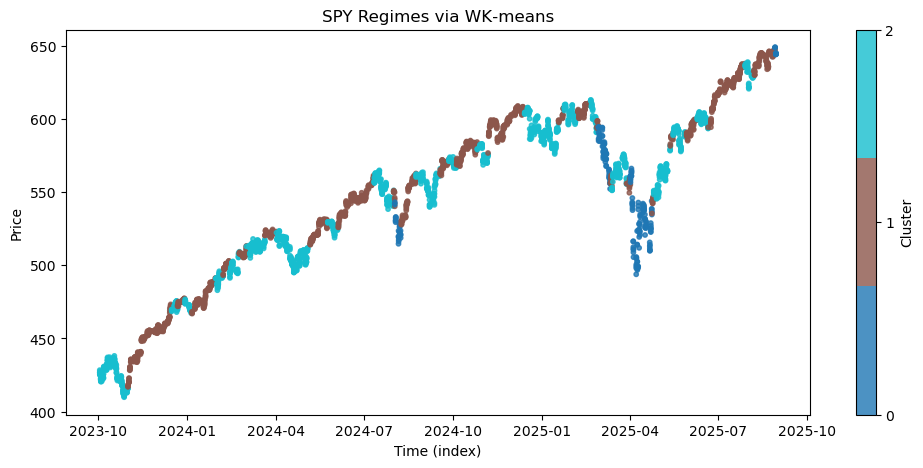

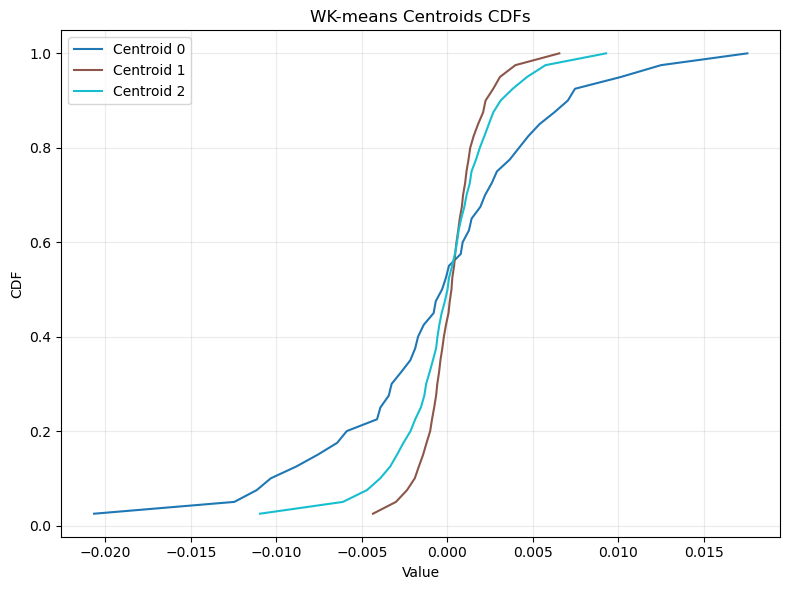

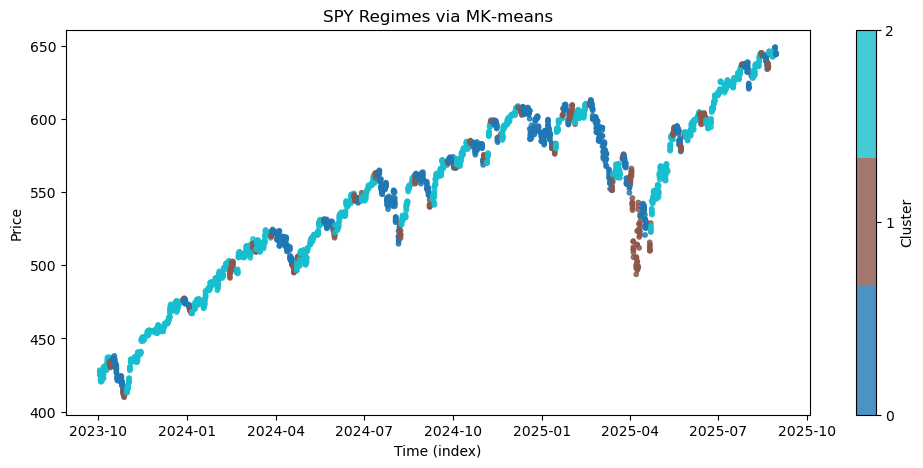

Evaluation:


Table 1. Scores for MK- and WK-means algorithms using traditional
k-means index evaluation methods, typical run.
Algorithm       Davies-Bouldin  Dunn            S̄ₐ       
------------------------------------------------------------
Wasserstein     4.9283          1.101e-01       0.0146    
Moment          1.1230          7.857e-02       0.0356    

Table 2. Self-similarity scores, WK- and MK-means algorithms.
Algorithm       C1              C2              C3             
------------------------------------------------------------
Wasserstein     0.0163         0.0038         0.0053        
Moment          0.0036         0.0305         0.0034        

Generating MMD distribution histograms...


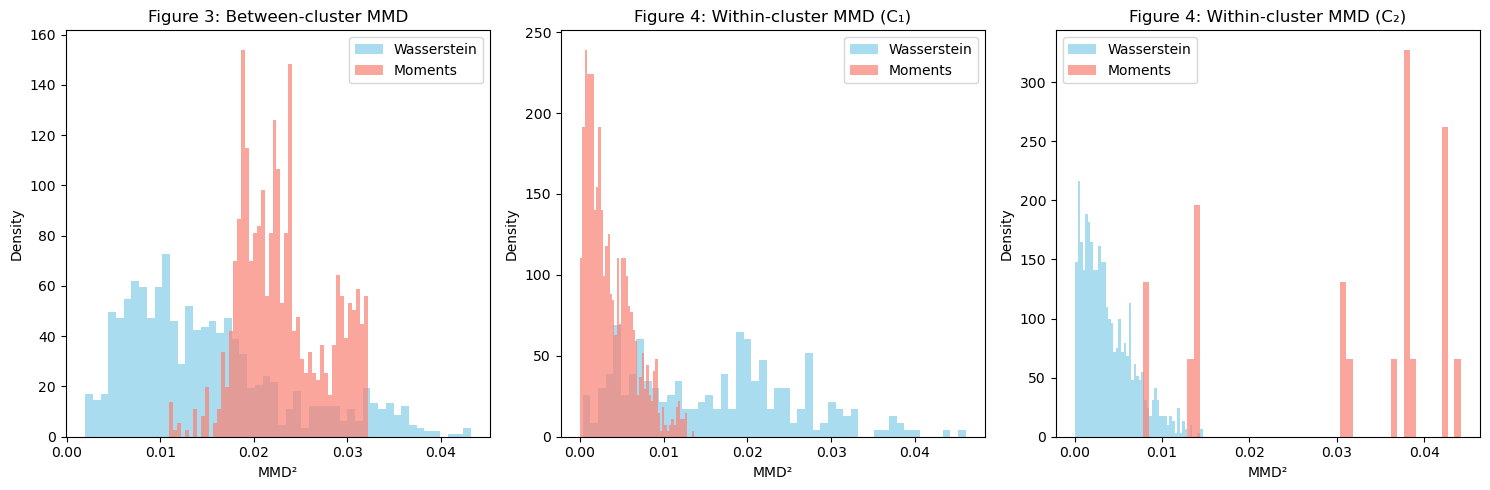

In [39]:
"""
Complete self-contained evaluation script for comparing WK-means and MK-means clustering.
This file includes all necessary classes and functions.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import wasserstein_distance
from typing import List, Tuple, Dict, Optional
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

class ClusteringEvaluator:
    """
    Comprehensive evaluation framework for comparing WK-means and MK-means clustering.
    Implements Davies-Bouldin, Dunn, Silhouette, and MMD-based metrics.
    """
    
    def __init__(self):
        self.results = {}
    
    def davies_bouldin_index(self, segments: np.ndarray, labels: np.ndarray, 
                            centroids: np.ndarray, distance_func=None) -> float:
        """
        Calculate Davies-Bouldin index (lower is better).
        """
        # Convert to numpy arrays if needed
        if isinstance(segments, list):
            segments = np.array(segments)
        if isinstance(labels, list):
            labels = np.array(labels)
        if isinstance(centroids, list):
            centroids = np.array(centroids)
            
        n_clusters = len(np.unique(labels))
        
        if distance_func is None:
            # For moment-based centroids, we need to extract moments from segments
            def compute_moments(seg, p):
                """Compute first p raw moments"""
                seg = np.asarray(seg, dtype=float).ravel()
                return np.array([np.mean(seg**n) for n in range(1, p + 1)])
            
            # Determine if centroids are moment-based (shape indicates p moments)
            if centroids.shape[1] <= 10:  # Likely moment-based
                # Use moment-space distance
                p = centroids.shape[1]
                def distance_func(seg, centroid):
                    if seg.shape == centroid.shape:
                        # Both are already in moment space
                        return np.linalg.norm(seg - centroid)
                    else:
                        # seg is raw data, centroid is moments
                        seg_moments = compute_moments(seg, p)
                        return np.linalg.norm(seg_moments - centroid)
            else:
                # Use Euclidean distance
                distance_func = lambda x, y: np.linalg.norm(x - y)
        
        # Calculate intra-cluster distances
        intra_dists = np.zeros(n_clusters)
        for i in range(n_clusters):
            mask = labels == i
            cluster_segments = segments[mask]
            if len(cluster_segments) > 0:
                dists = [distance_func(seg, centroids[i]) for seg in cluster_segments]
                intra_dists[i] = np.mean(dists)
        
        # Calculate DB index
        db_values = []
        for i in range(n_clusters):
            max_ratio = 0
            for j in range(n_clusters):
                if i != j:
                    inter_dist = distance_func(centroids[i], centroids[j])
                    if inter_dist > 0:
                        ratio = (intra_dists[i] + intra_dists[j]) / inter_dist
                        max_ratio = max(max_ratio, ratio)
            db_values.append(max_ratio)
        
        return np.mean(db_values)
    
    def dunn_index(self, segments: np.ndarray, labels: np.ndarray, 
                   distance_func=None) -> float:
        """
        Calculate Dunn index (higher is better).
        """
        # Convert to numpy arrays if needed
        if isinstance(segments, list):
            segments = np.array(segments)
        if isinstance(labels, list):
            labels = np.array(labels)
            
        n_clusters = len(np.unique(labels))
        
        if distance_func is None:
            distance_func = lambda x, y: np.linalg.norm(x - y)
        
        # Calculate minimum inter-cluster distance
        min_inter_dist = float('inf')
        for i in range(n_clusters):
            for j in range(i+1, n_clusters):
                cluster_i = segments[labels == i]
                cluster_j = segments[labels == j]
                if len(cluster_i) > 0 and len(cluster_j) > 0:
                    # Sample for efficiency if clusters are large
                    n_samples = min(50, len(cluster_i), len(cluster_j))
                    idx_i = np.random.choice(len(cluster_i), n_samples, replace=False)
                    idx_j = np.random.choice(len(cluster_j), n_samples, replace=False)
                    
                    for seg_i in cluster_i[idx_i]:
                        for seg_j in cluster_j[idx_j]:
                            dist = distance_func(seg_i, seg_j)
                            min_inter_dist = min(min_inter_dist, dist)
        
        # Calculate maximum intra-cluster distance
        max_intra_dist = 0
        for i in range(n_clusters):
            cluster_segments = segments[labels == i]
            if len(cluster_segments) > 1:
                # Sample for efficiency
                n_samples = min(50, len(cluster_segments))
                indices = np.random.choice(len(cluster_segments), n_samples, replace=False)
                sampled = cluster_segments[indices]
                
                for j in range(len(sampled)):
                    for k in range(j+1, len(sampled)):
                        dist = distance_func(sampled[j], sampled[k])
                        max_intra_dist = max(max_intra_dist, dist)
        
        if max_intra_dist == 0:
            return float('inf')
        
        return min_inter_dist / max_intra_dist
    
    def silhouette_coefficient(self, segments: np.ndarray, labels: np.ndarray, 
                              sample_size: int = None, alpha: float = 0.2) -> float:
        """
        Calculate average Silhouette coefficient.
        """
        # Convert to numpy arrays if needed
        if isinstance(segments, list):
            segments = np.array(segments)
        if isinstance(labels, list):
            labels = np.array(labels)
            
        n_samples = len(segments)
        n_clusters = len(np.unique(labels))
        
        if n_clusters == 1:
            return 0.0
        
        # Sample for efficiency
        if sample_size is None:
            sample_size = int(alpha * n_samples)
        sample_size = min(sample_size, n_samples)
        
        indices = np.random.choice(n_samples, sample_size, replace=False)
        sampled_segments = segments[indices]
        sampled_labels = labels[indices]
        
        silhouette_scores = []
        
        for i, seg in enumerate(sampled_segments):
            label = sampled_labels[i]
            
            # Calculate a_i: mean intra-cluster distance
            same_cluster = sampled_segments[sampled_labels == label]
            if len(same_cluster) > 1:
                a_i = np.mean([np.linalg.norm(seg - other) 
                              for other in same_cluster if not np.array_equal(other, seg)])
            else:
                a_i = 0
            
            # Calculate b_i: minimum mean inter-cluster distance
            b_i = float('inf')
            for other_label in range(n_clusters):
                if other_label != label:
                    other_cluster = sampled_segments[sampled_labels == other_label]
                    if len(other_cluster) > 0:
                        mean_dist = np.mean([np.linalg.norm(seg - other) 
                                           for other in other_cluster])
                        b_i = min(b_i, mean_dist)
            
            if b_i == float('inf'):
                s_i = 0
            else:
                s_i = (b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) > 0 else 0
            
            silhouette_scores.append(s_i)
        
        return np.mean(silhouette_scores)
    
    def mmd_gaussian_kernel(self, X: np.ndarray, Y: np.ndarray, 
                           sigma: float = 0.1) -> float:
        """
        Calculate Maximum Mean Discrepancy with Gaussian kernel.
        """
        m, n = len(X), len(Y)
        
        if m == 0 or n == 0:
            return 0.0
        
        # Reshape if needed
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        if Y.ndim == 1:
            Y = Y.reshape(-1, 1)
        
        # Kernel computations
        K_XX = np.exp(-cdist(X, X, 'euclidean')**2 / (2 * sigma**2))
        K_YY = np.exp(-cdist(Y, Y, 'euclidean')**2 / (2 * sigma**2))
        K_XY = np.exp(-cdist(X, Y, 'euclidean')**2 / (2 * sigma**2))
        
        # MMD^2 estimate
        mmd2 = (np.sum(K_XX) / (m * m) + 
                np.sum(K_YY) / (n * n) - 
                2 * np.sum(K_XY) / (m * n))
        
        return np.sqrt(max(0, mmd2))
    
    def compute_mmd_distributions(self, segments: np.ndarray, labels: np.ndarray,
                                 n_samples: int = 10000) -> Dict:
        """
        Compute between-cluster and within-cluster MMD distributions.
        """
        # Convert to numpy arrays if needed
        if isinstance(segments, list):
            segments = np.array(segments)
        if isinstance(labels, list):
            labels = np.array(labels)
            
        n_clusters = len(np.unique(labels))
        
        # Between-cluster MMD
        between_mmd = []
        if n_clusters >= 2:
            cluster_0 = segments[labels == 0]
            cluster_1 = segments[labels == 1]
            
            # Limit samples for computational efficiency
            n_samples_between = min(n_samples, len(cluster_0) * len(cluster_1))
            
            for _ in range(n_samples_between):
                idx_0 = np.random.randint(0, len(cluster_0))
                idx_1 = np.random.randint(0, len(cluster_1))
                
                x = cluster_0[idx_0]
                y = cluster_1[idx_1]
                
                mmd = self.mmd_gaussian_kernel(x, y)
                between_mmd.append(mmd)
        
        # Within-cluster MMD
        within_mmd = {i: [] for i in range(n_clusters)}
        for cluster_id in range(n_clusters):
            cluster = segments[labels == cluster_id]
            if len(cluster) > 1:
                n_samples_within = min(n_samples, len(cluster) * (len(cluster) - 1) // 2)
                
                for _ in range(n_samples_within):
                    idx1, idx2 = np.random.choice(len(cluster), 2, replace=False)
                    x = cluster[idx1]
                    y = cluster[idx2]
                    mmd = self.mmd_gaussian_kernel(x, y)
                    within_mmd[cluster_id].append(mmd)
        
        return {'between': between_mmd, 'within': within_mmd}
    
    def similarity_score(self, mmd_values: List[float]) -> float:
        """
        Calculate similarity score from MMD distribution.
        """
        if len(mmd_values) == 0:
            return 0.0
        return np.mean(mmd_values)
    
    def plot_mmd_histograms(self, wk_mmd: Dict, mk_mmd: Dict):
        """
        Plot between-cluster and within-cluster MMD histograms.
        """
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Between-cluster MMD
        ax = axes[0]
        if len(wk_mmd['between']) > 0:
            ax.hist(wk_mmd['between'], bins=50, alpha=0.7, label='Wasserstein', 
                    color='skyblue', density=True)
        if len(mk_mmd['between']) > 0:
            ax.hist(mk_mmd['between'], bins=50, alpha=0.7, label='Moments', 
                    color='salmon', density=True)
        ax.set_xlabel('MMD²')
        ax.set_ylabel('Density')
        ax.set_title('Figure 3: Between-cluster MMD')
        ax.legend()
        
        # Within-cluster MMD for C1
        ax = axes[1]
        if 0 in wk_mmd['within'] and len(wk_mmd['within'][0]) > 0:
            ax.hist(wk_mmd['within'][0], bins=50, alpha=0.7, label='Wasserstein',
                   color='skyblue', density=True)
        if 0 in mk_mmd['within'] and len(mk_mmd['within'][0]) > 0:
            ax.hist(mk_mmd['within'][0], bins=50, alpha=0.7, label='Moments',
                   color='salmon', density=True)
        ax.set_xlabel('MMD²')
        ax.set_ylabel('Density')
        ax.set_title('Figure 4: Within-cluster MMD (C₁)')
        ax.legend()
        
        # Within-cluster MMD for C2
        ax = axes[2]
        if 1 in wk_mmd['within'] and len(wk_mmd['within'][1]) > 0:
            ax.hist(wk_mmd['within'][1], bins=50, alpha=0.7, label='Wasserstein',
                   color='skyblue', density=True)
        if 1 in mk_mmd['within'] and len(mk_mmd['within'][1]) > 0:
            ax.hist(mk_mmd['within'][1], bins=50, alpha=0.7, label='Moments',
                   color='salmon', density=True)
        ax.set_xlabel('MMD²')
        ax.set_ylabel('Density')
        ax.set_title('Figure 4: Within-cluster MMD (C₂)')
        ax.legend()
        
        plt.tight_layout()
        plt.show()

def evaluate_both_methods(wk_pipeline_result: Dict, mk_pipeline_result: Dict):
    """
    Evaluate and compare WK-means and MK-means clustering results.
    
    Args:
        wk_pipeline_result: Result dictionary from WK-means pipeline with keys:
            - segments: numpy array or list of segments
            - labels: cluster labels
            - centroids: cluster centroids
        mk_pipeline_result: Result dictionary from MK-means pipeline with same keys
    
    Returns:
        Dictionary containing evaluation metrics and comparison tables
    """
    
    # Extract data and convert to numpy arrays if needed
    wk_segments = wk_pipeline_result['segments']
    wk_labels = wk_pipeline_result['labels']
    wk_centroids = wk_pipeline_result['centroids']
    
    mk_segments = mk_pipeline_result['segments']
    mk_labels = mk_pipeline_result['labels']
    mk_centroids = mk_pipeline_result['centroids']
    
    # Convert to numpy arrays if they are lists
    if isinstance(wk_segments, list):
        wk_segments = np.array(wk_segments)
    if isinstance(wk_labels, list):
        wk_labels = np.array(wk_labels)
    if isinstance(wk_centroids, list):
        wk_centroids = np.array(wk_centroids)
        
    if isinstance(mk_segments, list):
        mk_segments = np.array(mk_segments)
    if isinstance(mk_labels, list):
        mk_labels = np.array(mk_labels)
    if isinstance(mk_centroids, list):
        mk_centroids = np.array(mk_centroids)
    
    # Initialize evaluator
    evaluator = ClusteringEvaluator()
    
    # Davies-Bouldin Index
    wk_db = evaluator.davies_bouldin_index(wk_segments, wk_labels, wk_centroids)
    mk_db = evaluator.davies_bouldin_index(mk_segments, mk_labels, mk_centroids)
    
    # Dunn Index
    wk_dunn = evaluator.dunn_index(wk_segments, wk_labels)
    mk_dunn = evaluator.dunn_index(mk_segments, mk_labels)
    
    # Silhouette Coefficient
    wk_silhouette = evaluator.silhouette_coefficient(wk_segments, wk_labels, alpha=0.2)
    mk_silhouette = evaluator.silhouette_coefficient(mk_segments, mk_labels, alpha=0.2)
    
    # Get unique labels to handle cases with 2 or 3 clusters
    wk_unique_labels = np.unique(wk_labels)
    mk_unique_labels = np.unique(mk_labels)
    n_wk_clusters = len(wk_unique_labels)
    n_mk_clusters = len(mk_unique_labels)
    
    # MMD distributions for WK-means
    wk_mmd = evaluator.compute_mmd_distributions(wk_segments, wk_labels, n_samples=1000)
    wk_self_sim = {}
    for i in range(n_wk_clusters):
        wk_self_sim[f'C{i+1}'] = evaluator.similarity_score(wk_mmd['within'].get(i, []))
    
    # MMD distributions for MK-means
    mk_mmd = evaluator.compute_mmd_distributions(mk_segments, mk_labels, n_samples=1000)
    mk_self_sim = {}
    for i in range(n_mk_clusters):
        mk_self_sim[f'C{i+1}'] = evaluator.similarity_score(mk_mmd['within'].get(i, []))
    
    
    print("\n" + "="*60)
    print("Table 1. Scores for MK- and WK-means algorithms using traditional")
    print("k-means index evaluation methods, typical run.")
    print("="*60)
    print(f"{'Algorithm':<15} {'Davies-Bouldin':<15} {'Dunn':<15} {'S̄ₐ':<10}")
    print("-"*60)
    print(f"{'Wasserstein':<15} {wk_db:<15.4f} {wk_dunn:<15.3e} {wk_silhouette:<10.4f}")
    print(f"{'Moment':<15} {mk_db:<15.4f} {mk_dunn:<15.3e} {mk_silhouette:<10.4f}")
    print("="*60)
    
    print("\n" + "="*60)
    print("Table 2. Self-similarity scores, WK- and MK-means algorithms.")
    print("="*60)
    
    # Print header based on actual number of clusters
    max_clusters = max(n_wk_clusters, n_mk_clusters)
    header = "Algorithm      "
    for i in range(max_clusters):
        header += f" C{i+1:<14}"
    print(header)
    print("-"*60)
    
    # Print WK-means self-similarity
    wk_row = f"{'Wasserstein':<15}"
    for i in range(max_clusters):
        if f'C{i+1}' in wk_self_sim:
            wk_row += f" {wk_self_sim[f'C{i+1}']:<14.4f}"
        else:
            wk_row += f" {'N/A':<14}"
    print(wk_row)
    
    # Print MK-means self-similarity
    mk_row = f"{'Moment':<15}"
    for i in range(max_clusters):
        if f'C{i+1}' in mk_self_sim:
            mk_row += f" {mk_self_sim[f'C{i+1}']:<14.4f}"
        else:
            mk_row += f" {'N/A':<14}"
    print(mk_row)
    print("="*60)
    
    # Plot MMD histograms
    print("\nGenerating MMD distribution histograms...")
    evaluator.plot_mmd_histograms(wk_mmd, mk_mmd)
    
    # Return results for further analysis
    results = {
        'metrics': pd.DataFrame({
            'Algorithm': ['Wasserstein', 'Moment'],
            'Davies-Bouldin': [wk_db, mk_db],
            'Dunn': [wk_dunn, mk_dunn],
            'Silhouette': [wk_silhouette, mk_silhouette]
        }),
        'self_similarity': {
            'wk': wk_self_sim,
            'mk': mk_self_sim
        },
        'mmd_distributions': {
            'wk': wk_mmd,
            'mk': mk_mmd
        }
    }
    
    return results

if __name__ == "__main__":
        
    wk_result = run_wk_spy_pipeline(p=1, k=3)  # Your WK-means pipeline
    mk_result = run_mk_spy_pipeline(p=2, k=3)  # Your MK-means pipeline  
    print("Evaluation:\n")
    # Step 3: Evaluate and compare
    results = evaluate_both_methods(wk_result, mk_result)

## Multi-Dimension Data

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from fastquant import get_crypto_data
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm

from src.testing import TestConfig
from src.testing.discriminators import AutoEvaluator, GeneralMMDDetector
from src.testing.discriminators.config import ProcessorConfig
from src.testing.experiment_functions.plot_result_functions import plot_path_test_threshold
from src.utils.Config import Config
from src.utils.auxiliary_classes.PathTransformer import PathTransformer, PathTransformerConfig
from src.utils.helper_functions.data_helper_functions import ema
from src.utils.helper_functions.global_helper_functions import get_project_root
from src.utils.helper_functions.plot_helper_functions import make_grid, golden_dimensions
from src.utils.helper_functions.test_helper_functions import get_memberships, get_sub_paths, get_grouped_paths, \
    get_alphas

/Users/Eric/opt/anaconda3/envs/mmd/lib/python3.7/site-packages/ccxt/base/exchange.py:32: CryptographyDeprecationWarning: Python 3.7 is no longer supported by the Python core team and support for it is deprecated in cryptography. The next release of cryptography will remove support for Python 3.7.
  from cryptography.hazmat import backends


In [31]:
import pandas as pd  

data_clean = pd.read_csv("data_clean.csv", header=[0,1], index_col=0, parse_dates=True)
vix_data = pd.read_csv("vix_data.csv", index_col=0, parse_dates=True)

In [40]:
data_clean

Price           Close                                                 \
Ticker             GE         IBM         JPM         KO          PG   
Date                                                                   
1980-03-17   1.374276    3.897010    1.047964   0.168411    0.546534   
1980-03-18   1.392650    3.929964    1.055669   0.172009    0.554125   
1980-03-19   1.366928    3.880534    1.071080   0.170570    0.560631   
1980-03-20   1.344881    3.839336    1.063375   0.169130    0.560631   
1980-03-21   1.359579    3.740470    1.086491   0.168411    0.561715   
...               ...         ...         ...        ...         ...   
2021-12-23  57.494400  112.164993  142.274139  52.031498  145.839630   
2021-12-27  57.873623  113.015045  143.088394  52.415794  147.543091   
2021-12-28  58.289539  113.882278  143.522644  52.621342  148.335587   
2021-12-29  57.977589  114.500504  143.450226  52.683903  149.565353   
2021-12-30  57.922554  114.981339  143.377869  52.531975  148.271835   

Price                                    High                          ...  \
Ticker            XOM        ^GSPC         GE         IBM         JPM  ...   
Date                                                                   ...   
1980-03-17   0.528294   102.260002   1.403673    3.979399    1.067229  ...   
1980-03-18   0.540899   104.099998   1.392650    3.971159    1.063375  ...   
1980-03-19   0.539753   104.309998   1.388975    3.938206    1.074933  ...   
1980-03-20   0.530585   103.120003   1.374277    3.905248    1.071080  ...   
1980-03-21   0.536316   102.309998   1.359579    3.831098    1.086491  ...   
...               ...          ...        ...         ...         ...  ...   
2021-12-23  53.402000  4725.790039  57.824687  112.448348  143.956894  ...   
2021-12-27  54.163383  4791.189941  57.904205  113.040804  143.124576  ...   
2021-12-28  53.988358  4786.350098  58.766618  114.388877  144.888746  ...   
2021-12-29  53.515770  4793.060059  58.399622  115.238940  144.418268  ...   
2021-12-30  53.200706  4778.729980  58.705454  115.376308  144.970161  ...   

Price             Open                           Volume                      \
Ticker              PG        XOM        ^GSPC       GE      IBM        JPM   
Date                                                                          
1980-03-17    0.563884   0.543191   105.230003  1497359  1735105    62775.0   
1980-03-18    0.547618   0.528294   102.260002  2268574  2065222    64125.0   
1980-03-19    0.554125   0.540899   104.099998  2535996  1541804    40500.0   
1980-03-20    0.560631   0.539753   104.309998  2175427  2005391    18900.0   
1980-03-21    0.560631   0.532878   103.120003  1806847  6192320    97200.0   
...                ...        ...          ...      ...      ...        ...   
2021-12-23  145.293068  53.533272  4703.959961  6236589  3649000  8055200.0   
2021-12-27  146.358881  53.323235  4733.990234  5503703  4293900  6188100.0   
2021-12-28  147.533979  54.180893  4795.490234  6503676  3445200  6342300.0   
2021-12-29  148.672647  53.804570  4788.640137  5602577  4239900  6398900.0   
2021-12-30  149.756639  53.577024  4794.229980  5247049  3158100  6948200.0   

Price                                                
Ticker            KO       PG       XOM       ^GSPC  
Date                                                 
1980-03-17   5707200  4150400   4883200    37020000  
1980-03-18   4166400  2729600   8656000    47340000  
1980-03-19   3628800  1494400   5798400    36520000  
1980-03-20   3096000  1072000   6958400    32580000  
1980-03-21   3940800   851200   4691200    32220000  
...              ...      ...       ...         ...  
2021-12-23  11027300  5640900  13543300  2913040000  
2021-12-27   9860000  4548600  12593700  2770290000  
2021-12-28   8979900  5929400  12781000  2707920000  
2021-12-29   9996000  5346100  12733600  2963310000  
2021-12-30   7703900  5911500  11940300  3124950000  

[10539 rows x 35 columns]

In [10]:
data_clean = data_clean[["Close"]]
np_data = data_clean.copy().to_numpy()

In [11]:
tickers = data_clean[["Close"]]["Close"].columns.values

In [12]:
cluster_path_real        = np.zeros((data_clean.shape[0], data_clean.shape[1] + 1))
cluster_path_real[:, 1:] = np_data
cluster_path_real[:, 0]  = data_clean.index.to_numpy()

snp_plot                 = np.zeros((data_clean.shape[0], 2))
snp_plot[:, 0]           = data_clean.index.to_numpy()
snp_plot[:, 1]           = np_data[:, -1]

In [17]:
import torch

# Force CPU (safe option)
DEVICE = torch.device("cpu")

In [13]:
path_transformer_config = PathTransformerConfig()

dt = 1/252  # Approximately

path_transformer_config.set_transformations({
    "standardise_path_transform":    (True,  0, {"s_type": "initial"}),
    "time_difference_transform":     (False, 0, {}),
    "time_normalisation_transform":  (True,  0, {}),
    "difference_transform":          (False, 0, {}),
    "translation_transform":         (False, 0, {}), 
    "scaling_transform":             (False, 0, {"sigmas": [dt**-0.5 for _ in range(len(tickers))]}),
    "cumulant_transform":            (False, 2, {}),
    "increment_transform":           (False, 2, {}),
    "lead_lag_transform":            (False, 3, {}),
    "invisibility_transform":        (False, 4, {}),
})

offset  = 0
n_steps = 8
n_paths = 8

real_test_config = TestConfig()
real_test_config.n_steps = n_steps
real_test_config.n_paths = n_paths
real_test_config.offset  = offset

n_steps_real = real_test_config.n_steps
n_paths_real = real_test_config.n_paths

pt          = PathTransformer(path_transformer_config)
sp_real     = get_sub_paths(cluster_path_real, n_steps, offset)
snp_sp_real = get_sub_paths(snp_plot, n_steps, offset)
mmd_real    = get_grouped_paths(sp_real, n_paths)
sp_t_real   = pt.transform_paths(sp_real.copy())
mmd_t_real  = get_grouped_paths(sp_t_real, n_paths)

100%|████████████████████████████████████| 1317/1317 [00:00<00:00, 28682.91it/s]


In [20]:
import torch

DEVICE = torch.device("cpu")   # <- force CPU

processor_config = ProcessorConfig()
processor_config.alpha_value = 0.95

processor_config.device = DEVICE

# processor_config = ProcessorConfig()

processor_config.override_args({
   "autoevaluator_kwargs": Config(**{
        "metric_kwargs": Config(**{
            "kernel_type": "rbf",
            "metric_type": "mmd",
            "sigmas": [1],
            "dyadic_orders": [2],
            "lambd": 1
        }),
        "n_scores": 200,
        "evaluator_kwargs": Config(**{
            "lags" : [-4, -8, -12],
            "threshold_method": "bootstrap",
        })
    })
})


auto_evaluator = AutoEvaluator(
    path_transformer = pt,
    processor_config = processor_config,
    test_config      = real_test_config
)

Metric initialized. MMD1, kernel = rbf, dyadic_order = 2


In [21]:
cluster_path_real

array([[3.22099200e+17, 1.37427628e+00, 3.89700985e+00, ...,
        5.46533883e-01, 5.28293610e-01, 1.02260002e+02],
       [3.22185600e+17, 1.39264953e+00, 3.92996430e+00, ...,
        5.54124773e-01, 5.40899277e-01, 1.04099998e+02],
       [3.22272000e+17, 1.36692786e+00, 3.88053370e+00, ...,
        5.60630798e-01, 5.39753497e-01, 1.04309998e+02],
       ...,
       [1.64064960e+18, 5.82895393e+01, 1.13882278e+02, ...,
        1.48335587e+02, 5.39883575e+01, 4.78635010e+03],
       [1.64073600e+18, 5.79775887e+01, 1.14500504e+02, ...,
        1.49565353e+02, 5.35157700e+01, 4.79306006e+03],
       [1.64082240e+18, 5.79225540e+01, 1.14981339e+02, ...,
        1.48271835e+02, 5.32007065e+01, 4.77872998e+03]])

In [22]:
real_data_scores = auto_evaluator.evaluate_path(cluster_path_real)

real_indexes_ = real_data_scores[0, :]
real_scores_  = real_data_scores[1, :]
real_alphas_  = real_data_scores[2, :]

100%|███████████████████████████████████████| 1298/1298 [00:14<00:00, 87.57it/s]


## Plot results

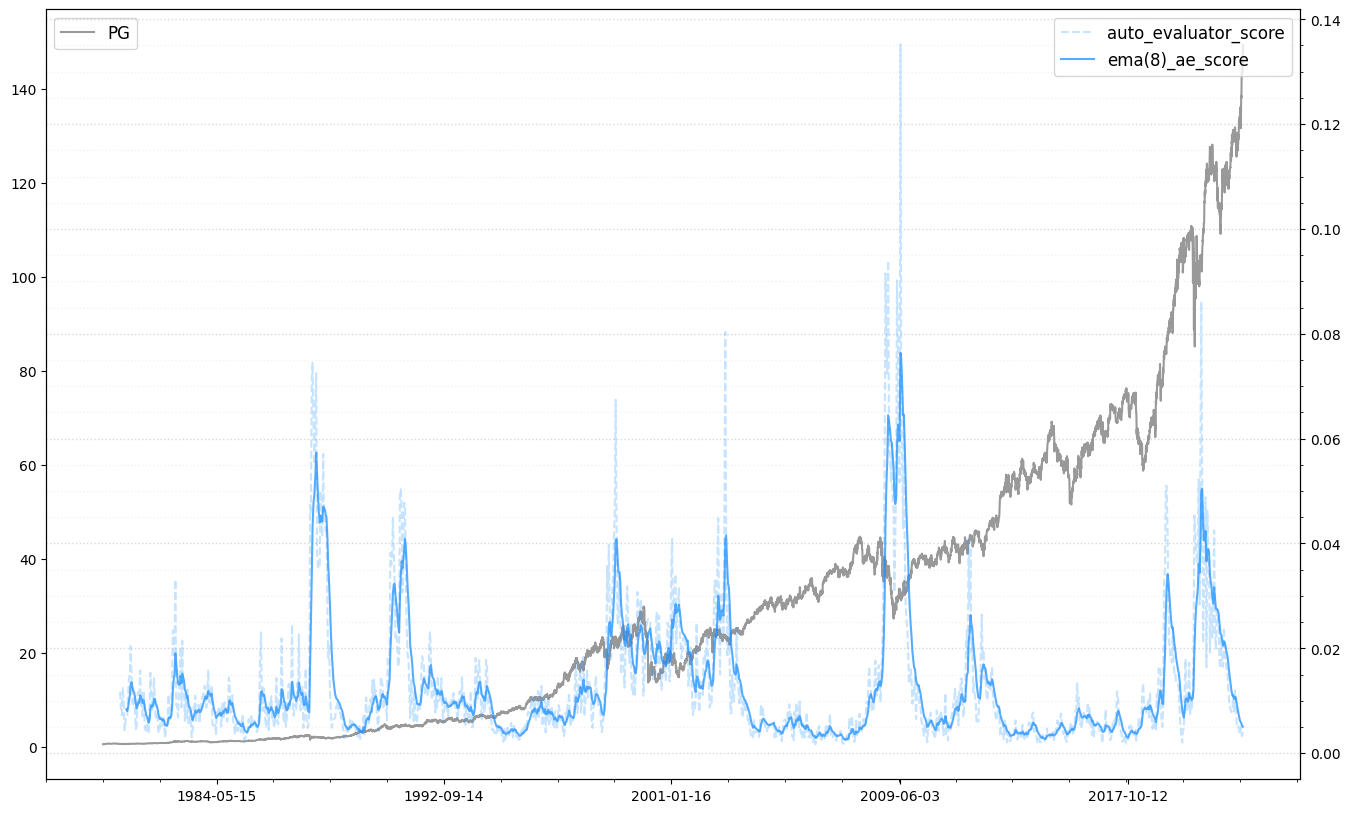

In [23]:
matplotlib.rc_file_defaults()

width = 10
price_indexes  = cluster_path_real[:, 0]
score_indexes  = real_indexes_
to = int(0.10*price_indexes.shape[0])

ind = 5

k = real_test_config.n_paths

plt.figure(figsize=golden_dimensions(width))
ax = plt.gca()

ax.plot(price_indexes, cluster_path_real[:, ind], color='black', alpha=0.4, label=tickers[ind-1])
ax2 = ax.twinx()
ax2.plot(score_indexes, real_scores_, color="dodgerblue", linestyle="dashed", alpha=0.25, label="auto_evaluator_score")
#ax2.plot(score_indexes, real_alphas_, color="tomato", alpha=0.25, label="crit_thresh")
ax2.plot(score_indexes[k-1:], ema(real_scores_, k), color="dodgerblue", alpha=0.75, label="ema({})_ae_score".format(k))
make_grid()
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), prop={'size': 12}, loc="upper left")
ax2.legend(loc="upper right", prop={'size': 12});
plt.xticks(price_indexes[to::2*to], list(map(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'), price_indexes[to::2*to])))
plt.show();

<Figure size 1618.03x1000 with 0 Axes>

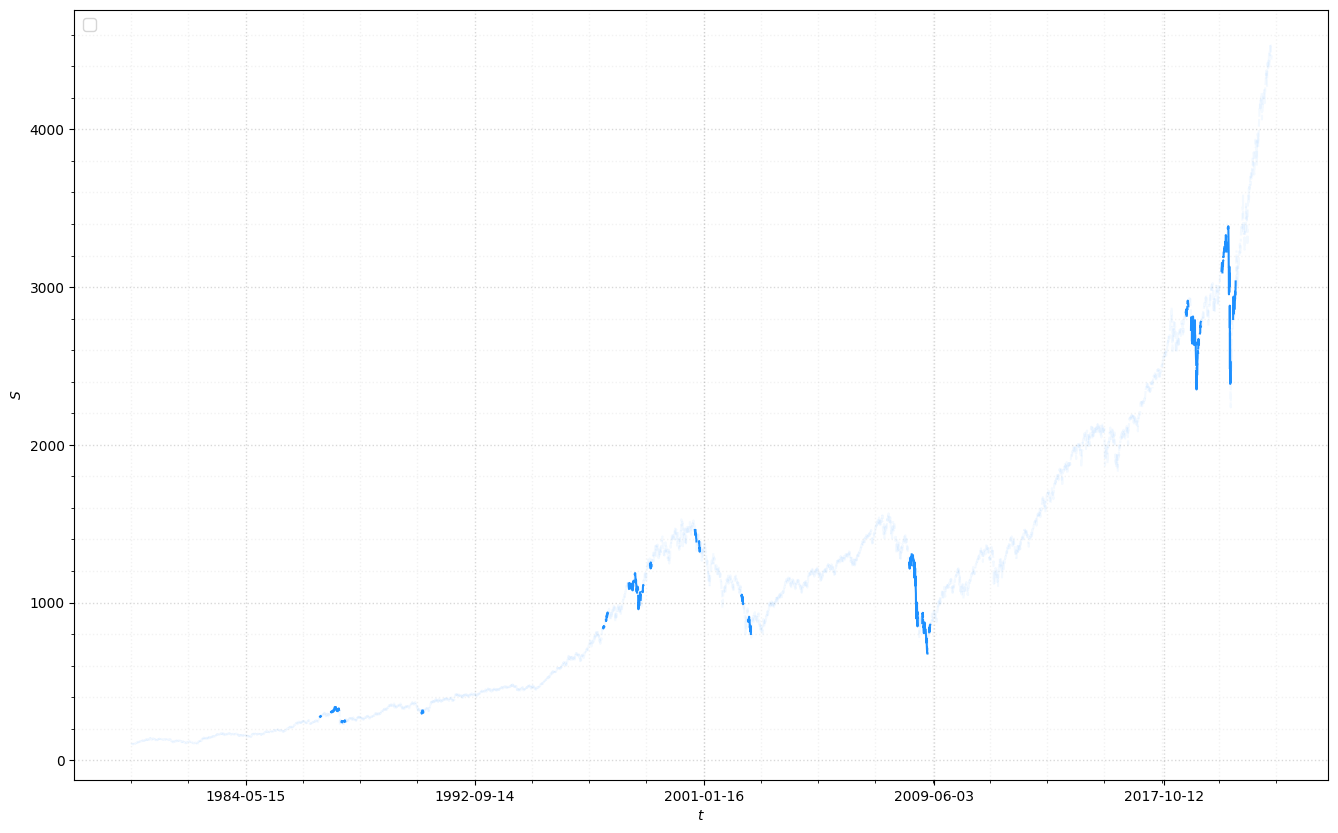

In [24]:
lags         = processor_config.autoevaluator_kwargs.evaluator_kwargs.lags
one_dim      = True
sub_paths    = snp_sp_real
alphas       = np.hstack([[0. for _ in range(len(lags) + n_paths - 1)], real_scores_ > real_alphas_])
as_timestamp = True
save_image   = [False]

plt.figure(figsize=golden_dimensions(10))
dim = sub_paths.shape[-1] - 1
plot_dim = dim if not one_dim else 1

for di in range(plot_dim):
    fig, ax = plt.subplots(1, 1 + di, figsize=golden_dimensions(width))
    ax.set_xlabel("$t$")
    ax.set_ylabel("$S$")

    for p, alph in zip(sub_paths, alphas):
        if alph == 0.0:
            ax.plot(p[:, 0], p[:, 1 + di], color='dodgerblue', linestyle="dashed", alpha=0.05)
        else:
            ax.plot(p[:, 0], p[:, 1 + di], color='dodgerblue', alpha=alph)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), prop={'size': 12}, loc="upper left")
    make_grid()

    if as_timestamp:
        indexes = sub_paths[:, :, 0].flatten()
        to = int(0.10*indexes.shape[0])
        ax.set_xticks(indexes[to::2*to])
        ax.set_xticklabels(list(map(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'), indexes[to::2*to])))

if save_image[0]:
    plt.savefig(get_project_root().as_posix() + "/data/images/alpha_plots/{}.png".format(save_image[1]), dpi=300)

plt.show()

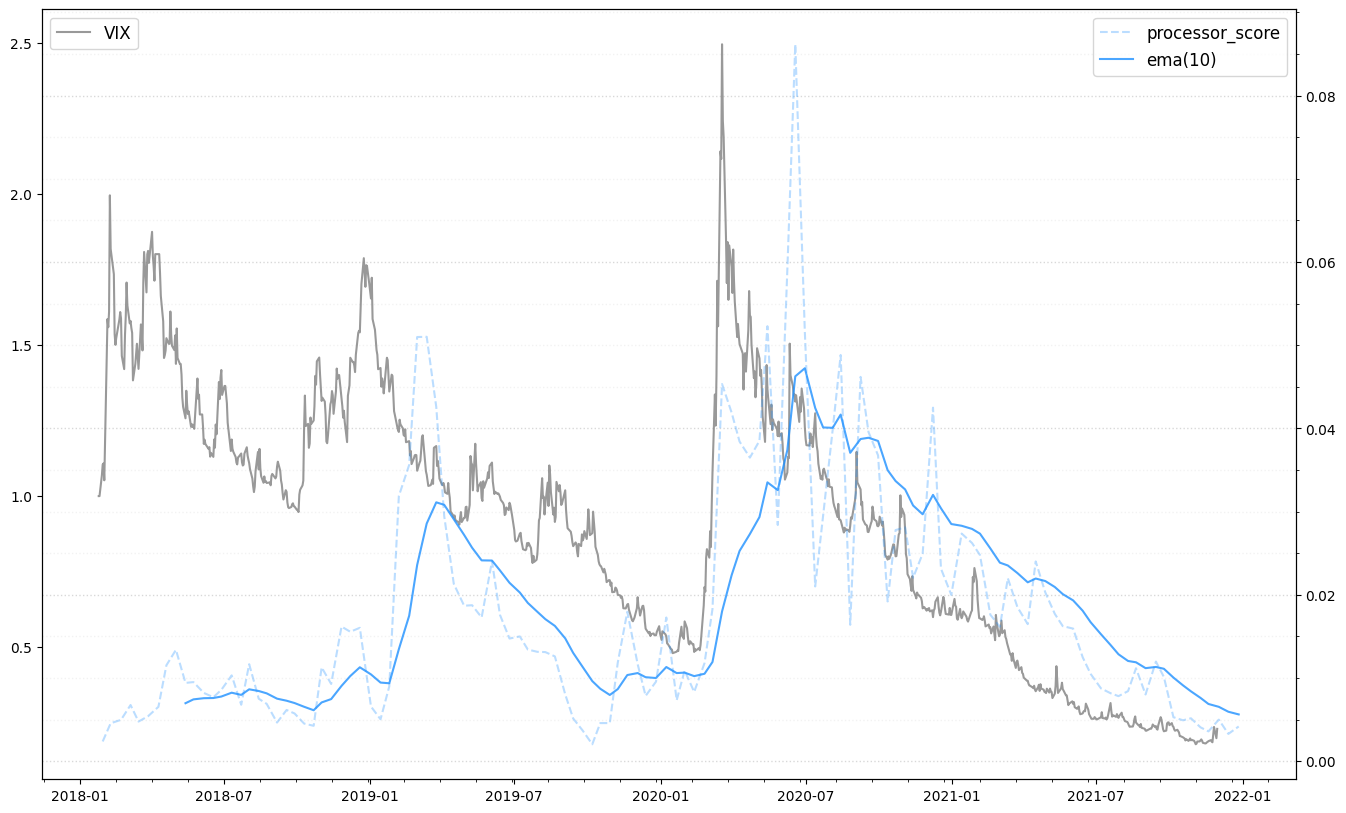

In [33]:
vix_indexes            = np.argwhere(np.array(list(map(lambda x: pd.Timestamp(x), score_indexes))) > vix_data.index[0]).T[0]
vix_index_values       = list(map(lambda x: pd.Timestamp(x), np.array(score_indexes)[vix_indexes]))
processor_vix_scores   = real_scores_[vix_indexes]

k = 10

plt.figure(figsize=golden_dimensions(width))
ax = plt.gca()
ax.plot(vix_data.index, vix_data.values/vix_data.values[0], color='grey', alpha=0.8, label="VIX")
ax2 = ax.twinx()
ax2.plot(vix_index_values, processor_vix_scores, color='dodgerblue', linestyle="dashed", alpha=0.3, label="processor_score")
ax2.plot(vix_index_values[k-1:], np.array(ema(processor_vix_scores, k)), color='dodgerblue', alpha=0.8, label="ema({})".format(k))
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), prop={'size': 12}, loc="upper left")
ax2.legend(loc="upper right", prop={'size': 12})
make_grid()

Given our chosen metric and collections of transformed ensemble paths, we can apply an AgglomerativeClustering algorithm over the matrix of pairwise MMD scores.

In [34]:
# Generate pairwise distance matrix D_ij = \mathcal{D}^r_\text{sig}(\boldsymbol{s}^i, \boldsymbol{s}^j)

num_paths              = mmd_t_real.shape[0]
res                    = np.zeros((num_paths, num_paths))
generate_pairwise_data = True

if generate_pairwise_data:
    for i in tqdm(range(num_paths)):
        path_i = mmd_t_real[i]
        for j in range(i, num_paths):
            path_j = mmd_t_real[j]
            score = auto_evaluator.metric(path_i, path_j)
            res[i, j] = score
            if i != j:
                res[j, i] = score
    np.save(get_project_root().as_posix() + "/data/real_data_pw_distances.npy", res, allow_pickle=True)
else:
    try:
        res = np.load(get_project_root().as_posix() + "/data/real_data_pw_distances.npy", allow_pickle=True)
    except FileNotFoundError:
        print("Pairwise data matrix has not been generated yet. Please generate pairwise distances first.")

100%|███████████████████████████████████████| 1310/1310 [52:12<00:00,  2.39s/it]


In [35]:
n_clusters = 6

clusters_real = AgglomerativeClustering(
    n_clusters = n_clusters, 
    affinity   = "precomputed", 
    linkage    = "complete"
).fit(res)

In [36]:
# Transform labels so the earlier clusters have fewer elements
from collections import Counter

def rank_unique_elements(lst):
    # Count the occurrences of each element
    counts = Counter(lst)

    # Sort the unique elements based on their counts in descending order
    ranked_elements = sorted(counts.items(), key=lambda x: x[1], reverse=True)

    # Extract the unique elements from the ranked list
    unique_elements = [item[0] for item in ranked_elements]

    return unique_elements

ranks = rank_unique_elements(clusters_real.labels_)
rank_dict = {r: i for i, r in enumerate(ranks)}
labels_real = [rank_dict[l] for l in clusters_real.labels_]

In [37]:
indexes_real = mmd_real[:, -1, -1, 0]
scores_real  = np.array(labels_real)
cluster_score_array_real = np.c_[indexes_real, scores_real]

In [38]:
# Get average membership for each sub-path
real_memberships      = get_memberships(mmd_real)
average_cluster_score = np.array([np.mean(scores_real[ind]) for ind in real_memberships])
average_indexes       = sp_real[:, -1, 0]

unique_scores = np.unique(average_cluster_score)
n_colors      = np.unique(average_cluster_score).shape[0]
cmap          = sns.diverging_palette(133, 20, l=60, n=n_colors, center="light")

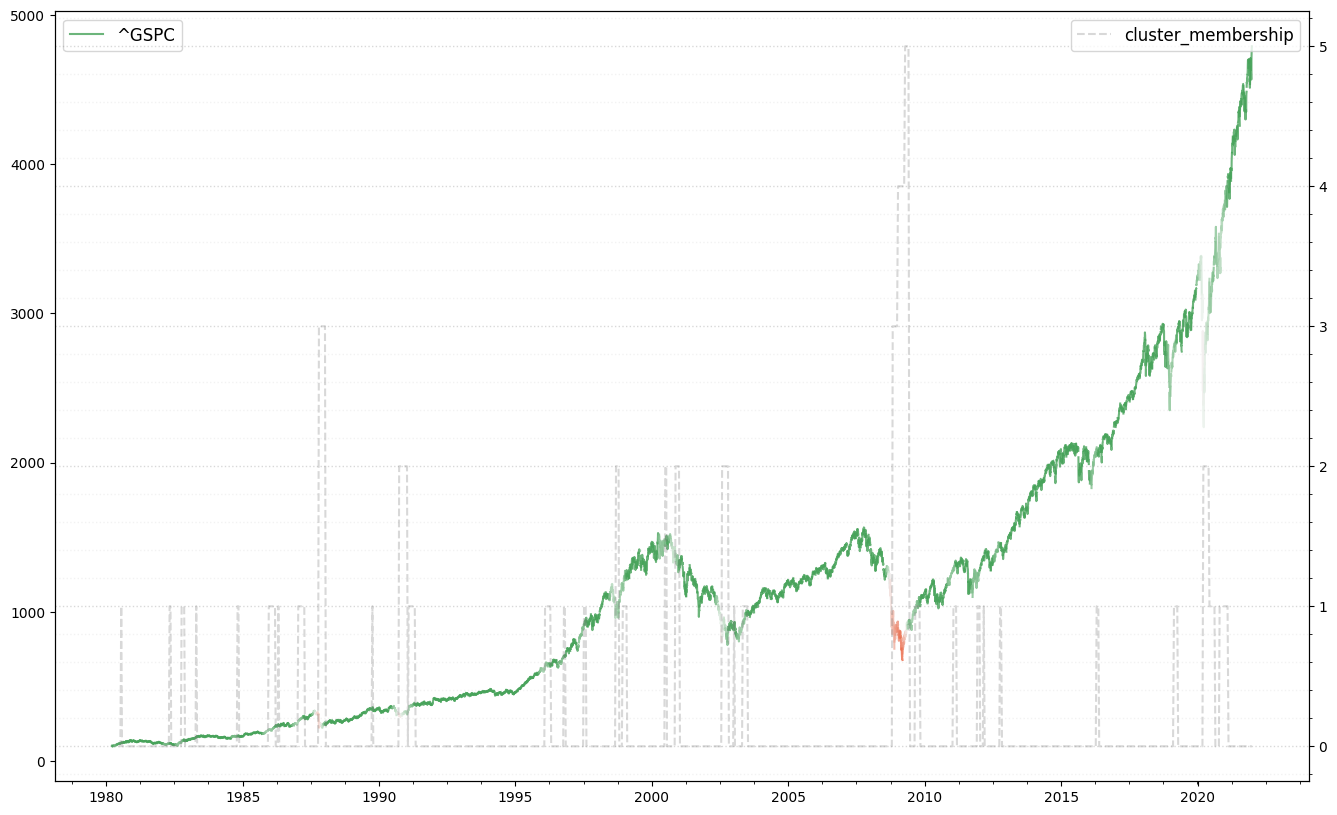

In [39]:
price_indexes   = [pd.Timestamp(x) for x in cluster_path_real[:, 0]]
score_indexes   = [pd.Timestamp(x) for x in indexes_real]
average_indexes = [pd.Timestamp(x) for x in average_indexes]
k=10

plt.figure(figsize=golden_dimensions(width))
ax = plt.gca()
for i, s in enumerate(sp_real):
    indexes = [pd.Timestamp(x) for x in s[:, 0]]
    color = cmap[int(np.argwhere(average_cluster_score[i] == unique_scores)[0][0])]
    ax.plot(indexes, s[:, -1], color=color, alpha=0.8, label="^GSPC")
ax2 = ax.twinx()
ax2.plot(score_indexes, scores_real, color='grey', alpha=0.3, label="cluster_membership", linestyle='dashed')
make_grid()
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), prop={'size': 12}, loc="upper left")
ax2.legend(loc="upper right", prop={'size': 12});

## Crypto Pairs